In [3]:
from typing import Tuple, Dict, List
from pathlib import Path
import numpy as np
import os
import sys


# Oder absoluten Pfad zum utils-Ordner
sys.path.append('/dss/dsshome1/08/di97ren/04-geo-oma24/assignment_04_geo_oma24-xView2/utils')

#from utils.helper import iterate_through_dir
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
from PIL import Image
#from utils.datasetClass import xView2Dataset, image_transform, transform, collate_fn
import torchvision.models as models
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
#from utils.model import UNet_ResNet50, SiameseUnet, train_step, val_step
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from torch.utils.tensorboard import SummaryWriter

ModuleNotFoundError: No module named 'numpy'

# Define all Classes and Functions

In [3]:

def iterate_through_dir(directory_path):
    for directory_path, directorynames, filenames in os.walk(directory_path):
        print(f"There are {len(directorynames)} directories and {len(filenames)} images in '{directory_path}'.")


def transform():
    """Transform für Bilder & Masken"""
    return v2.Compose([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.RandomRotation(degrees=15),
        v2.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        v2.ToDtype(torch.float32, scale=True)  # Automatische Skalierung auf [0,1]
    ])

def image_transform():
    """Nur für RGB-Bilder"""
    return v2.Compose([
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class xView2Dataset(Dataset):

    def __init__(self,
                 png_path: str,
                 target_path: str,
                 transform: callable = None,
                 image_transform: callable = None,
                 inference = False):
        
        self.png_path = png_path
        self.target_path = target_path
        self.transform = transform
        self.image_transform = image_transform
        

        # get all pre-disaster images:
        self.pre_images = sorted(self.png_path.glob("*_pre_disaster.png"))
        
        self.pairs = [] #

        for pre_img_path in self.pre_images:
            post_img_path = self.png_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")

            post_target_path = self.target_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")
            pre_target_path = pre_target_path = self.target_path / pre_img_path.name


            if post_img_path.exists() and post_target_path.exists() and pre_target_path.exists():
                self.pairs.append((pre_img_path, post_img_path, pre_target_path, post_target_path))

        assert len(self.pairs) > 0, "No matching image-pairs found!"

        # super().__init__()

    def __len__(self):
        return len(self.pre_images)

    def __getitem__(self, index):
        pre_img_path, post_img_path, pre_target_path, post_target_path = self.pairs[index]

        # load images and target masks with 
        
        pre_img = Image.open(pre_img_path).convert("RGB")
        post_img = Image.open(post_img_path).convert("RGB")
        pre_target_mask = Image.open(pre_target_path).convert('L')
        post_target_mask = Image.open(post_target_path).convert('L')

        # convert to numpy arrays
        pre_img = np.array(pre_img, dtype=np.float32) / 255.0
        post_img = np.array(post_img, dtype=np.float32) / 255.0
        pre_target_mask = np.array(pre_target_mask, dtype=np.float32)
        post_target_mask = np.array(post_target_mask, dtype=np.float32)

        # convert to Tensor
        pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        post_img = torch.tensor(post_img).permute(2, 0, 1)
        pre_target_mask = torch.tensor(pre_target_mask).unsqueeze(0)  # (H, W) → (1, H, W)
        post_target_mask = torch.tensor(post_target_mask).unsqueeze(0)

    # Transformation (optional)


        if self.transform:
            stack = torch.cat([pre_img, post_img, pre_target_mask, post_target_mask], dim=0)  # (8, H, W)
            stack = self.transform(stack)

            pre_img, post_img, pre_target_mask, post_target_mask = stack[:3], stack[3:6], stack[6:7], stack[7:8]
        
        if self.image_transform:
            
            # Nur auf Bilder Normalisierung anwenden
            pre_img = self.image_transform(pre_img)
            post_img = self.image_transform(post_img)

        return pre_img, post_img, pre_target_mask, post_target_mask 
    

    
def collate_fn(batch):
      # Extrahieren der einzelnen Daten aus der Batch-Liste
    pre_imgs, post_imgs, pre_masks, post_masks = zip(*batch)

    # Stapeln der Tensoren entlang der Batch-Dimension (erste Dimension)
    pre_imgs = torch.stack(pre_imgs, dim=0)
    post_imgs = torch.stack(post_imgs, dim=0)
    pre_masks = torch.stack(pre_masks, dim=0)
    post_masks = torch.stack(post_masks, dim=0)

    return pre_imgs, post_imgs, pre_masks, post_masks


class UNet_ResNet50(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Load ResNet50 als Encoder
        resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        
        # Encoder-Pfad
        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )
        
        # Decoder mit progressivem Upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        # Finale Klassifikationsschicht
        self.final_conv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Speichere Ursprungsgröße
        original_size = x.shape[2:]
        
        try:
            # Encoder-Durchgang
            features = self.encoder(x)
            #print(f"Encoder Output Shape: {features.shape}")

            # Decoder-Durchgang
            decoder_out = self.decoder(features)
            #print(f"Decoder Output Shape: {decoder_out.shape}")

            # Finale Konvolution
            out = self.final_conv(decoder_out)
            #print(f"Final Conv Output Shape: {out.shape}")

            # Upsample auf Originalgröße
            out = F.interpolate(out, size=original_size, mode='bilinear', align_corners=False)
            #print(f"Final Interpolated Output Shape: {out.shape}")

            return out

        except Exception as e:
            print(f"Error in forward pass: {e}")
            raise




class SiameseUnet(nn.Module):
    def __init__(self, num_pre_classes=2, num_post_classes=6):
        super(SiameseUnet, self).__init__()

        self.unet_preDisaster = UNet_ResNet50(n_class=num_pre_classes)
        self.unet_postDisaster = UNet_ResNet50(n_class=num_post_classes)

        # Fusion-Layer kombiniert prä- und post-Klassifikationen
        self.fusion_layer = nn.Sequential(
            nn.Conv2d(num_pre_classes + num_post_classes, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_pre_classes + num_post_classes, kernel_size=1)
        )

    def forward(self, pre_image, post_image):
        pre_output = self.unet_preDisaster(pre_image)
        post_output = self.unet_postDisaster(post_image)

        # Konkatenieren der Ausgaben
        fused_output = torch.cat([pre_output, post_output], dim=1)

        # Fusion der Features
        final_output = self.fusion_layer(fused_output)

        return final_output

def train_step(model, dataloader, loss_fn, optimizer, epoch):
    model.train()
    train_loss = 0.0

    precision_pre = MulticlassPrecision(num_classes=2).to(device)
    recall_pre = MulticlassRecall(num_classes=2).to(device)
    f1_pre = MulticlassF1Score(num_classes=2).to(device)
    
    precision_post = MulticlassPrecision(num_classes=6).to(device)
    recall_post = MulticlassRecall(num_classes=6).to(device)
    f1_post = MulticlassF1Score(num_classes=6).to(device)
    
    for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
        X_pre = pre_imgs.to(device)
        y_pre = pre_masks.to(device)
        X_post = post_imgs.to(device)
        y_post = post_masks.to(device)

        # Forward pass
        pred = model(X_pre, X_post)

        # Prepare masks      
        y_pre_metric = y_pre.squeeze(1).long()
        y_post_metric = y_post.squeeze(1).long()

        # Loss Berechnung
        # Pre-Bilder: erste 2 Kanäle (Klassen 0,1)
        loss_pre = loss_fn(pred[:, :2], y_pre_metric)
        
        # Post-Bilder: letzte 6 Kanäle (Klassen 0,1,2,3,4,5)
        loss_post = loss_fn(pred[:, 2:], y_post_metric)
        
        loss = loss_pre + loss_post
        
        # Optimizer-Schritte
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metriken aktualisieren für pre-Bilder
        precision_pre.update(pred[:, :2], y_pre_metric)
        recall_pre.update(pred[:, :2], y_pre_metric)
        f1_pre.update(pred[:, :2], y_pre_metric)

        # Metriken aktualisieren für post-Bilder
        precision_post.update(pred[:, 2:], y_post_metric)
        recall_post.update(pred[:, 2:], y_post_metric)
        f1_post.update(pred[:, 2:], y_post_metric)

        train_loss += loss.item()

    # Metriken berechnen
    precision_pre_value = precision_pre.compute()
    recall_pre_value = recall_pre.compute()
    f1_pre_value = f1_pre.compute()
    
    precision_post_value = precision_post.compute()
    recall_post_value = recall_post.compute()
    f1_post_value = f1_post.compute()

    # TensorBoard Logging
    writer.add_scalar("Loss/Train", train_loss / len(dataloader), epoch)
    
    # Logging für pre-Bilder
    writer.add_scalar("Precision_Pre/Train", precision_pre_value.mean(), epoch)
    writer.add_scalar("Recall_Pre/Train", recall_pre_value.mean(), epoch)
    writer.add_scalar("F1_Score_Pre/Train", f1_pre_value.mean(), epoch)
    
    # Logging für post-Bilder
    writer.add_scalar("Precision_Post/Train", precision_post_value.mean(), epoch)
    writer.add_scalar("Recall_Post/Train", recall_post_value.mean(), epoch)
    writer.add_scalar("F1_Score_Post/Train", f1_post_value.mean(), epoch)

    avg_train_loss = train_loss / len(dataloader) 

    return avg_train_loss

def val_step(model, dataloader, loss_fn, epoch):
    num_batches = len(dataloader)
    model.eval()

    val_loss = 0.0

    precision_pre = MulticlassPrecision(num_classes=2).to(device)
    recall_pre = MulticlassRecall(num_classes=2).to(device)
    f1_pre = MulticlassF1Score(num_classes=2).to(device)
    
    precision_post = MulticlassPrecision(num_classes=6).to(device)
    recall_post = MulticlassRecall(num_classes=6).to(device)
    f1_post = MulticlassF1Score(num_classes=6).to(device)

    with torch.no_grad():
        for pre_imgs, post_imgs, pre_masks, post_masks in dataloader:
            X_pre = pre_imgs.to(device)
            y_pre = pre_masks.to(device)
            X_post = post_imgs.to(device)
            y_post = post_masks.to(device)

            # Forward pass
            pred = model(X_pre, X_post)

            # Prepare masks      
            y_pre_metric = y_pre.squeeze(1).long()
            y_post_metric = y_post.squeeze(1).long()

            # Loss Berechnung
            val_loss_pre = loss_fn(pred[:, :2], y_pre_metric)
            val_loss_post = loss_fn(pred[:, 2:], y_post_metric)
            val_loss += (val_loss_pre.item() + val_loss_post.item())

            # Metriken aktualisieren für pre-Bilder
            precision_pre.update(pred[:, :2], y_pre_metric)
            recall_pre.update(pred[:, :2], y_pre_metric)
            f1_pre.update(pred[:, :2], y_pre_metric)

            # Metriken aktualisieren für post-Bilder
            precision_post.update(pred[:, 2:], y_post_metric)
            recall_post.update(pred[:, 2:], y_post_metric)
            f1_post.update(pred[:, 2:], y_post_metric)

        val_loss /= num_batches

        # Metriken berechnen
        precision_pre_value = precision_pre.compute().cpu().numpy()
        recall_pre_value = recall_pre.compute().cpu().numpy()
        f1_pre_value = f1_pre.compute().cpu().numpy()
        
        precision_post_value = precision_post.compute().cpu().numpy()
        recall_post_value = recall_post.compute().cpu().numpy()
        f1_post_value = f1_post.compute().cpu().numpy()

        # TensorBoard Logging
        writer.add_scalar("Loss/Val", val_loss, epoch)
        
        # Logging für pre-Bilder
        writer.add_scalar("Precision_Pre/Val", precision_pre_value.mean(), epoch)
        writer.add_scalar("Recall_Pre/Val", recall_pre_value.mean(), epoch)
        writer.add_scalar("F1_Score_Pre/Val", f1_pre_value.mean(), epoch)
        
        # Logging für post-Bilder
        writer.add_scalar("Precision_Post/Val", precision_post_value.mean(), epoch)
        writer.add_scalar("Recall_Post/Val", recall_post_value.mean(), epoch)
        writer.add_scalar("F1_Score_Post/Val", f1_post_value.mean(), epoch)

        return val_loss


# Define all pathes

In [4]:
# HPC Terrabyte
# adapt the user to your needs
USER = "di97ren"
# keep the following unchanged
ROOT = Path("/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022")
USER_PATH = ROOT / f"users/{USER}"
DATA_PATH = ROOT / "data"


# Configure the path to the xview2 dataset for your environment
DATASET_ROOT = DATA_PATH / "xview2-subset"

TRAIN_ROOT = DATASET_ROOT / "train"
TRAIN_IMG = TRAIN_ROOT / "png_images"
TRAIN_TARGET = TRAIN_ROOT / 'targets'

VAL_ROOT = DATASET_ROOT / "val"
VAL_IMG = VAL_ROOT / "png_images"
VAL_TARGET = VAL_ROOT / 'targets'


Get overview over content of directories

In [4]:
print(iterate_through_dir(DATASET_ROOT))

There are 7 directories and 0 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2-subset'.
There are 2 directories and 0 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2-subset/train'.
There are 0 directories and 200 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2-subset/train/targets'.
There are 0 directories and 200 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2-subset/train/png_images'.
There are 0 directories and 40 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2-subset/label'.
There are 0 directories and 40 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2-subset/images'.
There are 2 directories and 0 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2-subset/val'.
There are 0 directories and 50 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2-subset/val/targets'.
There are 0 directories and 50 images in '/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/data/xview2-subset/val/png_images'.
Th

# Create Training and Validation Datasets

In [5]:
train_dataset = xView2Dataset(png_path = TRAIN_IMG,
                 target_path = TRAIN_TARGET,
                 transform = transform(),
                 image_transform = image_transform()
                 )

val_dataset = xView2Dataset(png_path = VAL_IMG ,
                 target_path = VAL_TARGET,
                 transform = transform(),
                 image_transform = image_transform()
                 )

train_dataset, val_dataset
len(train_dataset), len(val_dataset)

(100, 25)

# Training

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4


In [7]:

train_dataloader = DataLoader(
    train_dataset,
    batch_size= 10, 
    collate_fn = collate_fn,
    shuffle= True,
    num_workers = num_workers,
    prefetch_factor=2, # number of preloaded batches for each workre
    drop_last= True
)

val_dataloader =  DataLoader(
    val_dataset,
    batch_size= 10, 
    collate_fn = collate_fn,
    shuffle= True,
    num_workers = num_workers,
    prefetch_factor=2, # number of preloaded batches for each workre
    drop_last= True
)


/dss/dsshome1/08/di97ren/04-geo-oma24/xView2SiameseUNet/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:

NUM_CLASSES = 6


EPOCHS = 40
EXPERIMENT_GROUP = "xView2"
EXPERIMENT_ID = "UNet_004"

# HPC Terrabyte path config
EXPERIMENT_DIR = USER_PATH / f"experiments/{EXPERIMENT_GROUP}"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINTS_DIR = USER_PATH / f"checkpoints/{EXPERIMENT_GROUP}"
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
model = SiameseUnet()
if torch.cuda.device_count() > 1:
    print(f"Verwende {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model = model.cuda()


writer = SummaryWriter(EXPERIMENT_DIR / EXPERIMENT_ID)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.008, momentum=0.9, weight_decay=1e-6)

#scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

## Start Training

In [9]:
_ = model.to(device)
best_val_loss = float('inf')
best_checkpoint_path = None

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    avg_train_loss = train_step(model, train_dataloader, loss_fn, optimizer, epoch)
    print(avg_train_loss)
    avg_val_loss = val_step(model, val_dataloader, loss_fn, epoch)
    print(avg_val_loss)
    #ROP: comment the scheduler below and use commeted lines instead
    scheduler.step()
    # scheduler.step(val_loss)
    # Modify your checkpoint saving code
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_checkpoint_path = CHECKPOINTS_DIR / f'{EXPERIMENT_GROUP}_{EXPERIMENT_ID}_epoch_{epoch}.pth'
        
        print(f"Attempting to save checkpoint to {best_checkpoint_path}")
        print(f"Directory exists: {CHECKPOINTS_DIR.exists()}")
        print(f"Directory is writable: {os.access(CHECKPOINTS_DIR, os.W_OK)}")
        
        try:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_val_loss,
            }, best_checkpoint_path)
            print(f'Successfully saved checkpoint at {best_checkpoint_path}')
        except Exception as e:
            print(f"Error saving checkpoint: {e}")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_checkpoint_path = CHECKPOINTS_DIR / f'{EXPERIMENT_GROUP}_{EXPERIMENT_ID}_epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': best_val_loss,
        }, best_checkpoint_path)
        print(f'Checkpoint saved at {best_checkpoint_path}')
        best_checkpoint_path_str = "val_loss:" + str(best_val_loss) + "@" + str(best_checkpoint_path)
        writer.add_text("Best Checkpoint Path", str(best_checkpoint_path_str), epoch)

    writer.add_scalar("LR", scheduler.get_last_lr()[0], epoch)


writer.close()
print("Done!")

Epoch 0


In [ ]:
# Save just the state dictionary (weights only)
torch.save(model.state_dict(), 'siamese_unet_weights.pth')

# Inference

In [ ]:
class xView2Dataset(Dataset):

    def __init__(self,
                 png_path: str,
                 target_path: callable = None,
                 transform: callable = None,
                 image_transform: callable = None,
                 inference = False):

        
        self.png_path = png_path
        self.target_path = target_path
        self.transform = transform
        self.image_transform = image_transform
        self.inference = inference

        

        # get all pre-disaster images:
        self.pre_images = sorted(self.png_path.glob("*_pre_disaster.png"))
        
        self.pairs = [] #

        for pre_img_path in self.pre_images:
            post_img_path = self.png_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")

            if self.inference: 
                if post_img_path.exists():
                    self.pairs.append((pre_img_path, post_img_path))
            else: 
                # Nur im Trainingsmodus benötigen wir target_path
                if self.target_path is None:
                    raise ValueError("target_path must be provided when not in inference mode")
                    
                post_target_path = self.target_path / pre_img_path.name.replace("_pre_disaster", "_post_disaster")
                pre_target_path = self.target_path / pre_img_path.name

                if post_img_path.exists() and post_target_path.exists() and pre_target_path.exists():
                    self.pairs.append((pre_img_path, post_img_path, pre_target_path, post_target_path))

        assert len(self.pairs) > 0, "No matching image-pairs found!"

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):

        if self.inference:
            pre_img_path, post_img_path = self.pairs[index]

            # Load images
            pre_img = Image.open(pre_img_path).convert("RGB")
            post_img = Image.open(post_img_path).convert("RGB")

            # Convert to numpy arrays
            pre_img = np.array(pre_img, dtype=np.float32) / 255.0
            post_img = np.array(post_img, dtype=np.float32) / 255.0

            # Convert to Tensor
            pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
            post_img = torch.tensor(post_img).permute(2, 0, 1)
            
            if self.image_transform:
                pre_img = self.image_transform(pre_img)
                post_img = self.image_transform(post_img)

            return pre_img, post_img, pre_img_path.name, post_img_path.name

        else:
            pre_img_path, post_img_path, pre_target_path, post_target_path = self.pairs[index]

            # load images and target masks with 
            
            pre_img = Image.open(pre_img_path).convert("RGB")
            post_img = Image.open(post_img_path).convert("RGB")
            pre_target_mask = Image.open(pre_target_path).convert('L')
            post_target_mask = Image.open(post_target_path).convert('L')

            # convert to numpy arrays
            pre_img = np.array(pre_img, dtype=np.float32) / 255.0
            post_img = np.array(post_img, dtype=np.float32) / 255.0
            pre_target_mask = np.array(pre_target_mask, dtype=np.float32)
            post_target_mask = np.array(post_target_mask, dtype=np.float32)

            # convert to Tensor
            pre_img = torch.tensor(pre_img).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
            post_img = torch.tensor(post_img).permute(2, 0, 1)
            pre_target_mask = torch.tensor(pre_target_mask).unsqueeze(0)  # (H, W) → (1, H, W)
            post_target_mask = torch.tensor(post_target_mask).unsqueeze(0)

            # Transformation (optional)
            if self.transform:
                stack = torch.cat([pre_img, post_img, pre_target_mask, post_target_mask], dim=0)  # (8, H, W)
                stack = self.transform(stack)

                pre_img, post_img, pre_target_mask, post_target_mask = stack[:3], stack[3:6], stack[6:7], stack[7:8]
            
            if self.image_transform:
                # Nur auf Bilder Normalisierung anwenden
                pre_img = self.image_transform(pre_img)
                post_img = self.image_transform(post_img)

            return pre_img, post_img, pre_target_mask, post_target_mask 
    
def collate_fn_test(batch):
    pre_imgs, post_imgs, pre_names, post_names = zip(*batch)
    # Stapeln der Tensoren entlang der Batch-Dimension (erste Dimension)
    pre_imgs = torch.stack(pre_imgs, dim=0)
    post_imgs = torch.stack(post_imgs, dim=0)

    return pre_imgs, post_imgs, pre_names, post_names

NameError: name 'Dataset' is not defined

Define Testroot and Dataloader

In [ ]:
TEST_ROOT = DATASET_ROOT / "test"
TEST_IMG = TEST_ROOT / "png_images"

test_dataset = xView2Dataset(png_path= TEST_IMG,
                 image_transform = image_transform(),
                 inference = True)


test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,  # Kann größer sein als beim Training
    collate_fn=collate_fn_test,
    shuffle=False,  # Bei Inference nicht shuffeln
    num_workers=5
)

In [ ]:
import os
from pathlib import Path

def find_best_checkpoint(checkpoint_dir, experiment_id="UNet_004"):
    """Find checkpoint with lowest validation loss in filename."""
    checkpoint_dir = Path(checkpoint_dir)
    checkpoints = list(checkpoint_dir.glob(f"*{experiment_id}*.pth"))
    
    if not checkpoints:
        print("No checkpoints found!")
        return None
    
    # Get the most recent checkpoint (usually best if you only save on improvement)
    latest_checkpoint = max(checkpoints, key=lambda x: os.path.getmtime(x))
    return latest_checkpoint

CHECKPOINTS_DIR = USER_PATH / f"checkpoints/{EXPERIMENT_GROUP}"
best_checkpoint_path = find_best_checkpoint(CHECKPOINTS_DIR)

In [ ]:
def load_checkpoint(model, checkpoint_path):
    """Load checkpoint accounting for DataParallel wrapper if needed."""
    checkpoint = torch.load(checkpoint_path)
    state_dict = checkpoint['model_state_dict']
    
    # Check if the state_dict was saved with DataParallel
    if list(state_dict.keys())[0].startswith('module.'):
        if not isinstance(model, torch.nn.DataParallel):
            new_state_dict = {k[7:]: v for k, v in state_dict.items() if k.startswith('module.')}
            state_dict = new_state_dict
    else:
        if isinstance(model, torch.nn.DataParallel):
            new_state_dict = {f'module.{k}': v for k, v in state_dict.items()}
            state_dict = new_state_dict
    
    model.load_state_dict(state_dict)
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['loss']}")
    return model

# Modell initialisieren
model = SiameseUnet(num_pre_classes=2, num_post_classes=6)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Optional: DataParallel (nur wenn nötig)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model = model.to(device)

# Besten Checkpoint laden
model = load_checkpoint(model, best_checkpoint_path)
#model.eval()  # Wichtig: In Evaluationsmodus setzen

Using 3 GPUs!
Loaded checkpoint from epoch 31 with loss 0.31029216200113297


DataParallel(
  (module): SiameseUnet(
    (unet_preDisaster): UNet_ResNet50(
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [19]:
def inference(model, dataloader):
    """
    Run inference on test data with added functionality.
    
    Args:
        model: Das siamesische U-Net Modell
        dataloader: Der Dataloader mit Testdaten
        output_dir: Verzeichnis zum Speichern (optional)
        save_results: Ob die Ergebnisse gespeichert werden sollen
        sample_to_visualize: Anzahl der zu visualisierenden Samples
    
    Returns:
        Dictionary mit Ergebnissen und Performance-Metriken
    """
   

    results = {
        'pre_predictions': [],
        'post_predictons': [],
        'pre_names': [],
        'post_nmaes'; []
        }
        
    model.eval()

    with torch.no_grad():
        for pre_imgs, post_imgs, pre_names, post_names in enumerate(dataloader):
            pre_imgs = pre_imgs.to(device)
            post_imgs = post_imgs.to(device)
            
            # Forward pass
            outputs = model(pre_imgs, post_imgs)
            
            # Split outputs
            pre_outputs = outputs[:, :2]  # Erste 2 Kanäle für pre-disaster 
            post_outputs = outputs[:, 2:]  # Letzte 6 Kanäle für post-disaster
            
            # Konvertiere Logits zu Klassenindizes durch Argmax
            pre_pred = torch.argmax(pre_outputs, dim=1).cpu().numpy()
            post_pred = torch.argmax(post_outputs, dim=1).cpu().numpy()
            
            results['pre_predictions'].extend(pre_pred)
            results['post_predictions'].extend(post_pred)
            results['pre_names'].extend(pre_names)
            results['post_names'].extend(post_names)

            total_samples += len(pre_names)

        end_time = time.time()
        elapsed_time = end_time - start_time

        results['performance'] = {
            'total_time': elapsed_time,
            'total_samples': total_samples,
            'samples_per_second': total_samples / elapsed_time,
            'time_per_sample': elapsed_time / total_samples
        }
            
    print(f"Inference abgeschlossen in {elapsed_time:.4f} Sekunden")
    print(f"Verarbeitungsgeschwindigkeit: {total_samples / elapsed_time:.2f} Bilder/Sekunde")
    
    return results




Inference complete. Results saved to /dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di97ren/predictions/xView2


In [ ]:
def visualize_predictions(results, indices=None, num_samples=3):
    """
    Visualisiert die Vorhersagen aus der Ergebnisstruktur.
    
    Args:
        results: Datenstruktur mit Vorhersagen
        indices: Liste von Indizes, die visualisiert werden sollen (optional)
        num_samples: Anzahl der zu visualisierenden Beispiele, wenn indices=None
    """
    if indices is None:
        indices = range(min(num_samples, len(results['pre_names'])))
    
    for idx in indices:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Pre-disaster Vorhersage
        axes[0].imshow(results['pre_predictions'][idx], cmap='gray')
        axes[0].set_title(f"Pre: {results['pre_names'][idx]}")
        
        # Post-disaster Vorhersage
        axes[1].imshow(results['post_predictions'][idx], cmap='viridis')
        axes[1].set_title(f"Post: {results['post_names'][idx]}")
        
        plt.tight_layout()
        plt.show()

def save_predictions(results, output_dir):
    """
    Speichert die Vorhersagen als Bilder.
    
    Args:
        results: Datenstruktur mit Vorhersagen
        output_dir: Verzeichnis zum Speichern
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    for i in range(len(results['pre_names'])):
        # Pre-disaster Maske speichern
        pre_mask = results['pre_predictions'][i].astype(np.uint8) * 255
        pre_mask_path = output_dir / f"pred_{results['pre_names'][i]}"
        Image.fromarray(pre_mask).save(pre_mask_path)
        
        # Post-disaster Maske speichern
        post_mask = results['post_predictions'][i].astype(np.uint8) * 50
        post_mask_path = output_dir / f"pred_{results['post_names'][i]}"
        Image.fromarray(post_mask).save(post_mask_path)
    
    print(f"Vorhersagen gespeichert in {output_dir}")

In [ ]:
# Inferenz durchführen
results = inference(model, test_dataloader)

# Einige Ergebnisse visualisieren
visualize_predictions(results, num_samples=5)


----------------------------------

In [20]:
# def visualize_predictions(img_path, mask_path, output_path=None):
#     """Visualize image with overlay mask."""
#     import matplotlib.pyplot as plt
#     from matplotlib.colors import ListedColormap
    
#     # Bild und Maske laden
#     img = np.array(Image.open(img_path))
#     mask = np.array(Image.open(mask_path))
    
#     # Plot erstellen
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(img)
    
#     # Farbige Overlay-Maske erstellen
#     # Für post-disaster: verschiedene Farben für unterschiedliche Schadensgrade
#     if "post" in str(mask_path):
#         # Farben für die verschiedenen Klassen
#         colors = [(0,0,0,0), 'yellow', 'orange', 'red', 'purple', 'black']
#         cmap = ListedColormap(colors)
#         mask_overlay = ax.imshow(mask, alpha=0.5, cmap=cmap, vmin=0, vmax=5)
#     else:  # pre-disaster: nur Buildings
#         colors = [(0,0,0,0), 'blue']
#         cmap = ListedColormap(colors)
#         mask_overlay = ax.imshow(mask, alpha=0.5, cmap=cmap, vmin=0, vmax=1)
    
#     plt.title(f"Image with prediction overlay")
    
#     if output_path:
#         plt.savefig(output_path, bbox_inches='tight')
#         plt.close()
#     else:
#         plt.show()

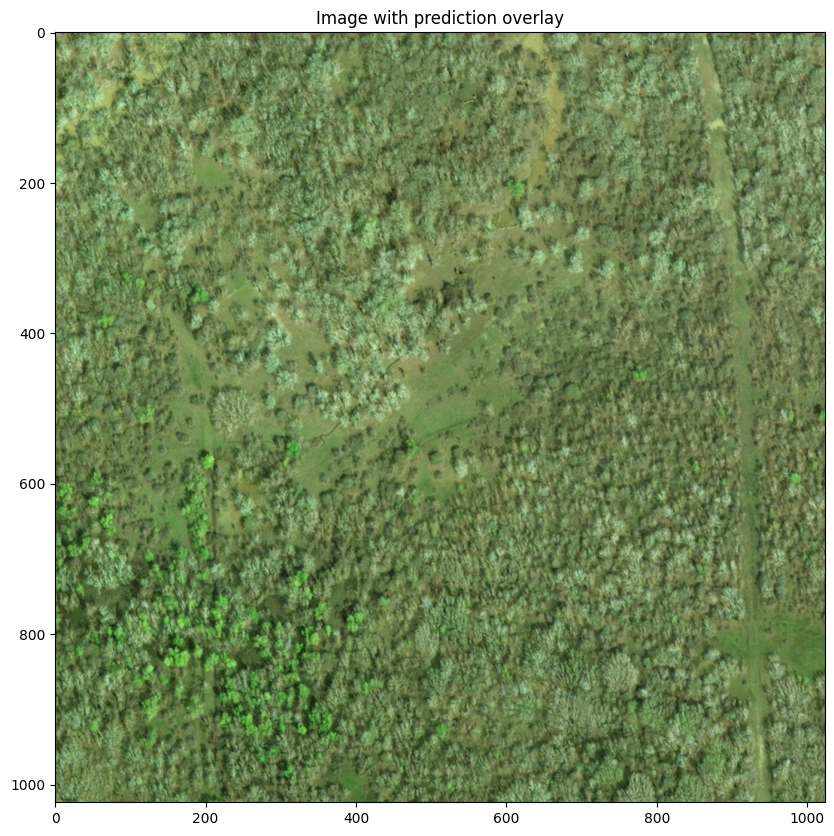

Visualisierung erstellt für: pred_hurricane-harvey_00000166_pre_disaster.png


In [26]:
# import os
# from pathlib import Path

# # Pfade definieren
# predictions_path = Path("/dss/dsstbyfs02/pn49ci/pn49ci-dss-0022/users/di97ren/predictions/xView2")
# original_images_path = TEST_IMG  # Verwenden Sie Ihre TEST_IMG Variable
# output_vis_path = predictions_path / "visualizations"

# # Ausgabeordner erstellen, falls er nicht existiert
# os.makedirs(output_vis_path, exist_ok=True)

# # Alle Vorhersagemasken durchgehen
# for mask_file in predictions_path.glob("*.png"):
#     # Entsprechendes Post-Disaster Bild finden
#     # Annahme: Die Vorhersagemaskendatei heißt ähnlich wie das Originalbild
#     # Möglicherweise müssen Sie die Namenskonvention anpassen
#     img_name = mask_file.name[5:]
    
#     # Wenn die Vorhersagen umbenannt wurden, müssen Sie hier entsprechend anpassen
#     if "_prediction" in img_name:
#         img_name = img_name.replace("_prediction", "")
    
#     img_path = original_images_path / img_name
    
#     # Überprüfen, ob das Originalbild existiert
#     if img_path.exists():
#         # Ausgabepfad für die Visualisierung
#         #output_path = output_vis_path / f"vis_{mask_file.name}"
#         output_path = None
#         # Visualisierung erstellen
#         visualize_predictions(img_path, mask_file, output_path)
#         print(f"Visualisierung erstellt für: {mask_file.name}")
#     else:
#         print(f"Warnung: Originalbild nicht gefunden für: {mask_file.name} (gesucht: {img_path})")

--------------------------------------------------------------------------------